In [1]:
# === Standard library ===
import json
import os

# === Third-party libraries ===
import numpy as np

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# === Local application-specific imports ===
from utils_uf_methods import *


In [ ]:
# select the best available device (GPU with CUDA if present, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# display additional information depending on the device type
if torch.cuda.is_available():
    # if a GPU is available, print CUDA version, cuDNN status, and the GPU name
    print(f"PyTorch CUDA version: {torch.version.cuda}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    # fallback case: CPU execution only
    print("CUDA not available. Running on CPU.")


In [ ]:
# Load dataset from JSON file
# The dataset is stored as a list of episodes, where each entry contains:
#   - a list of observations (per-step state/action info)
#   - a success flag (1 if the episode ended successfully, 0 otherwise)
#   - the episode length (number of steps)
#   - possibly other metadata depending on how it was saved
with open('./u_e_test/datasets/standard_2200087.json') as f:
    raw_dataset = json.load(f)

In [ ]:
corrected_dataset = []

# Loop over each episode in the raw dataset
for ep in raw_dataset:
    new_ep = []
    prev_state = None

    # Iterate over the steps of the current episode
    for step in ep:
        # Each step seems to contain features + the last 2 entries (likely actions)
        # Here we "shift" the actions of the *previous state* so they align with the *current step*
        if prev_state is not None:
            # Build a corrected step by combining:
            #   - all features of the current step except the last 2
            #   - the last 2 elements (actions) from the previous step
            new_ep.append(step[:-2] + prev_state[-2:])

        # Keep track of the current step to use its actions in the next iteration
        prev_state = step

    # Add the corrected episode to the dataset
    corrected_dataset.append(new_ep)


In [ ]:
# Flatten corrected dataset into a tensor
states = torch.tensor([step for episodio in corrected_dataset for step in episodio])

# Flatten raw dataset into a tensor
old_states = torch.tensor([step for episodio in raw_dataset for step in episodio])

# Split into train (60%), val (20%), test (20%)
states = split_dataset(states)
old_states = split_dataset(old_states)


In [ ]:
# Small constant to prevent division by zero in normalization
STD_EPSILON = 1e-6

# Mean of training set (old_states[0] = train split)
old_states_mean = old_states[0].mean(dim=0, keepdim=True)

# Std of training set (+epsilon for numerical stability)
old_states_std = old_states[0].std(dim=0, keepdim=True) + STD_EPSILON

In [ ]:
# Mean and std for standardization (use only training set)
states_mean = states[0].mean(dim=0, keepdim=True)
states_std = states[0].std(dim=0, keepdim=True) + STD_EPSILON

# Keep calibration set without standardization
calibration_not_std = old_states[2]

# Apply standardization to all splits
for i in range(len(states)):
    states[i] = (states[i] - states_mean) / states_std
    

# Wrap splits into dataset objects
states_dataset = (SupervisedDataset(states[0]),  # train
                  SupervisedDataset(states[1]),  # val
                  SupervisedDataset(states[2]),  # cal
                  SupervisedDataset(states[3]))  # test

# Calibration datasets (non-standardized and old standardized)
calibration_not_std_dataset = SupervisedDataset(calibration_not_std)
old_calibration_dataset = SupervisedDataset((old_states[2] - old_states_mean) / old_states_std)

# DataLoaders for each split
states_loader = (DataLoader(states_dataset[0], batch_size=256, shuffle=True),
                 DataLoader(states_dataset[1], batch_size=256, shuffle=True),
                 DataLoader(states_dataset[2], batch_size=256, shuffle=True),
                 DataLoader(states_dataset[3], batch_size=256, shuffle=True))

calibration_not_std_loader = DataLoader(calibration_not_std_dataset, batch_size=256, shuffle=True)
old_calibration_loader = DataLoader(old_calibration_dataset, batch_size=256, shuffle=True)


# Training

In [ ]:
# Hyperparameter search settings
learning_rates = [0.001, 0.0005]
weight_decays = [1e-6, 1e-5, 1e-4]
n_runs = 1  # number of runs per configuration

'''
# Loop over runs, weight decays, and learning rates
for run_idx in range(1, n_runs + 1):
    for wd in weight_decays:
        for lr in learning_rates:
        
            prefix = f"prob_lr{lr}_wd{wd}_run{run_idx}"
            print(f"Training {prefix}")

            # Train probabilistic world model with given hyperparameters
            train_world_model_prob(
                prefix_name=prefix,
                train_loader=states_loader[0],
                val_loader=states_loader[1],
                device=device,
                hidden_layers=[128, 128, 128],
                stable_variant=False,
                max_epochs=500,  # lower for quick tests
                learning_rate=lr,
                weight_decay=wd,
                patience=8
            )
'''


In [ ]:
# Hyperparameter search settings
learning_rates = [3e-4, 1e-3, 3e-3]
weight_decays = [1e-6, 1e-5, 1e-4]
dropouts = [0.05, 0.1, 0.2]
n_runs = 1  # number of runs per configuration

# Example of previous best runs
# last   = mcd_lr0.001_wd1e-06_do0.1_run2
# last_2 = mcd_lr0.0003_wd0.0001_do0.05_run2

'''
# Grid search over runs, weight decays, learning rates, and dropouts
for run_idx in range(1, n_runs + 1):
    for wd in weight_decays:
        for lr in learning_rates:
            for d in dropouts:
                
                prefix = f"mcd_lr{lr}_wd{wd}_do{d}_run{run_idx}"
                print(f"Training {prefix}")

                # Train MC Dropout world model with given hyperparameters
                train_mc_dropout_world_model(
                    prefix_name=prefix,
                    train_loader=states_loader[0],
                    val_loader=states_loader[1],
                    device=device,
                    hidden_layers=[128, 128, 128],
                    dropout_prob=d,
                    max_epochs=500,
                    learning_rate=lr,
                    weight_decay=wd,
                    patience=8
                )
'''


# Eval

In [ ]:
# Path where trained Q-networks are stored
path = './new_models/base_2179199'

# Initialize an ensemble of 5 Q-networks
qf_ensemble = [DenseSoftQNetwork((4, 17), 7*4, 2, [128,128,128]) for _ in range(5)]

# Load best weights for each network in the ensemble
for i, q in enumerate(qf_ensemble):
    q.load_state_dict(torch.load(os.path.join(path, f'qf{i+1}_best.pth')))

# Set all networks to evaluation mode (disable dropout, batchnorm updates, etc.)
for q in qf_ensemble:
    q.eval()

In [ ]:
# Load trained parameters for the probabilistic world model
prob_world_params = torch.load('./u_e_test/unc_models/prob_lr0.001_wd1e-05_run1_1757498773_jazzy_tapir.pth')

# Initialize model with same input/output dimensions and architecture
prob_world = ProbabilisticWorldModel(74, 24, [128,128,128], True)

# Load saved weights into the model
prob_world.load_state_dict(prob_world_params)

# Switch to evaluation mode (disable dropout, etc.)
prob_world.eval()

In [ ]:
# Load trained parameters for the MC Dropout world model
mcd_world_params = torch.load('./u_e_test/unc_models/mcd_lr0.0003_wd1e-05_do0.1_run1_1757492976_daffy_marshmallow.pth')

# Initialize MC Dropout model (input=74, output=24, 3 hidden layers, dropout=0.1)
mcd_world = MCDropoutWorldModel(74, 24, [128,128,128], 0.1)

# Load saved weights
mcd_world.load_state_dict(mcd_world_params)

# Switch to evaluation mode (Dropout always active)
mcd_world.eval()

In [ ]:
# Load trained parameters for the RND model
rnd_params = torch.load('./u_e_test/ood_models/rnd_7346509_uptight_vortex.pth')

# Initialize RND networks: source = fixed random target, predictor = trained network
rnd_source = RNDNetwork(96, [128,128,128])
rnd_predictor = RNDNetwork(96, [128,128,128])

# Load saved weights into predictor and source networks
rnd_predictor.load_state_dict(rnd_params['predictor_state_dict'])
rnd_source.load_state_dict(rnd_params['random_state_dict'])

# Set both networks to evaluation mode
rnd_predictor.eval()
rnd_source.eval()

In [ ]:
# List of uncertainty functions, one per model
funcs = [
    # Probabilistic world model uncertainty
    lambda x: compute_uncertainties_prob(prob_world, x),

    # MC Dropout world model uncertainty (20 stochastic forward passes)
    lambda x: compute_uncertainties_mcd(mcd_world, x, 20),

    # Q-network ensemble uncertainty
    lambda x: compute_uncertainties_QNet(qf_ensemble, x)
]

[probabilistic] AUC: 0.7749 | Threshold ottimale (Youden): 3.3774
[mcd] AUC: 0.9062 | Threshold ottimale (Youden): 1.1677
[qnet] AUC: 0.9495 | Threshold ottimale (Youden): 0.2703


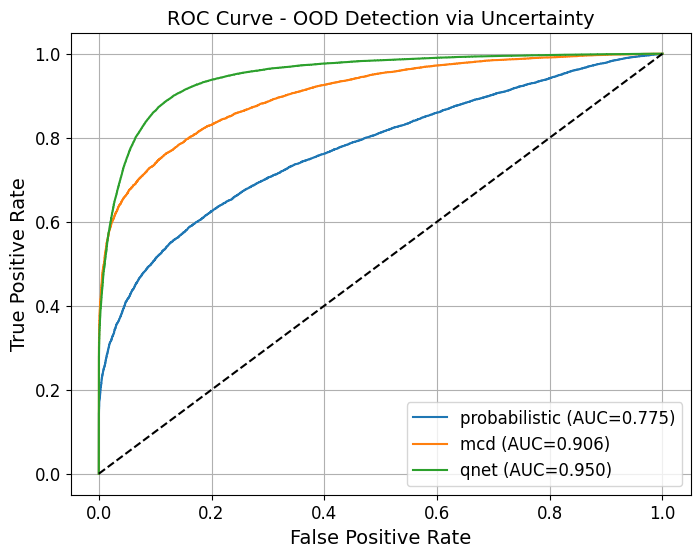

In [18]:
res = evaluate_ood_detection_multiple(funcs, ['probabilistic', 'mcd', 'qnet', 'rnd'], 
                                 [states_loader[3], states_loader[3], calibration_not_std_loader, states_loader[3]])

In [ ]:
def print_percentiles(name, data):
    # Percentiles to compute
    percentiles = torch.tensor([1,10,20,30,40,50,60,65,70,75,80,85,90,95,99], dtype=torch.float32)

    # Ensure input is a torch tensor
    if not isinstance(data, torch.Tensor):
        data = torch.from_numpy(data)

    # Compute percentile values
    values = torch.quantile(data, percentiles / 100.0)
    results = list(zip(percentiles.tolist(), values.tolist()))
    
    # Print nicely formatted output
    print(f"{name} percentiles:")
    for x in results:
        print(f"  {x[0]}th percentile: {x[1]}")
        
    return results


In [ ]:
# Store percentile results for each model
prob = []

# Calibration loaders: standardized (prob, mcd) and non-standardized (QNet)
loaders = [states_loader[2], states_loader[2], calibration_not_std_loader]

# Evaluate uncertainty functions and print percentiles
for i, f in enumerate(funcs):
    d = f(loaders[i])
    prob.append(print_percentiles(f"{['probabilistic', 'mcd', 'qnet'][i]} model", d))


probabilistic model percentiles:
  1.0th percentile: 0.07126705348491669
  10.0th percentile: 0.30804702639579773
  20.0th percentile: 0.5498977899551392
  30.0th percentile: 0.7814002633094788
  40.0th percentile: 1.021934986114502
  50.0th percentile: 1.2947192192077637
  60.0th percentile: 1.6259264945983887
  65.0th percentile: 1.8369672298431396
  70.0th percentile: 2.0703060626983643
  75.0th percentile: 2.392136573791504
  80.0th percentile: 2.8639121055603027
  85.0th percentile: 3.556211471557617
  90.0th percentile: 4.722108840942383
  95.0th percentile: 7.529963970184326
  99.0th percentile: 15.85285758972168
mcd model percentiles:
  1.0th percentile: 0.2653093934059143
  10.0th percentile: 0.3618978261947632
  20.0th percentile: 0.439064085483551
  30.0th percentile: 0.5121616721153259
  40.0th percentile: 0.5843691825866699
  50.0th percentile: 0.657550573348999
  60.0th percentile: 0.7382341027259827
  65.0th percentile: 0.7862593531608582
  70.0th percentile: 0.839761495

In [ ]:
# Model configuration (architecture + variant flag)
args = {
    'input_dim': 74,
    'output_dim': 24,
    'hidden_layers': [128, 128, 128],
    'stable_variant': False,
}

# Save model checkpoint with extra info
torch.save({
    'model_parameters': prob_world.state_dict(),  # trained weights
    'model_args': args,                           # architecture settings
    'input_mean': torch.cat([                     # selected mean features for normalization
        states_mean[:, :17*3],
        states_mean[:, 17*4 : 17*4 + 7*3],
        states_mean[:, -2:]], dim=1),
    'input_std': torch.cat([                      # selected std features for normalization
        states_std[:, :17*3],
        states_std[:, 17*4 : 17*4 + 7*3],
        states_std[:, -2:]], dim=1),
    'percentiles': prob[0]                        # uncertainty distribution (prob model)
}, './u_e_test/prob_world_method.pth')


In [ ]:
# Model configuration (architecture + dropout probability)
args = {
    'input_dim': 74,
    'output_dim': 24,
    'hidden_layers': [128, 128, 128],
    'dropout_prob': 0.1,
}

# Save MC Dropout model checkpoint with extra info
torch.save({
    'model_parameters': mcd_world.state_dict(),  # trained weights
    'model_args': args,                          # architecture + dropout setting
    'input_mean': torch.cat([                    # selected mean features for normalization
        states_mean[:, :17*3],
        states_mean[:, 17*4 : 17*4 + 7*3],
        states_mean[:, -2:]], dim=1),
    'input_std': torch.cat([                     # selected std features for normalization
        states_std[:, :17*3],
        states_std[:, 17*4 : 17*4 + 7*3],
        states_std[:, -2:]], dim=1),
    'percentiles': prob[1]                       # uncertainty distribution (MC Dropout)
}, './u_e_test/mcd_world_method.pth')


In [ ]:
# Q-network ensemble configuration
args = {
    'raycast_observation_shape': (4, 17),  # LiDAR-like input (4 channels × 17 rays)
    'state_observation_size': 7*4,         # additional state features
    'action_size': 2,                      # number of actions
    'dense_layer': [128, 128, 128],        # hidden layer sizes
}

# Save Q-network ensemble checkpoint with extra info
torch.save({
    'model_parameters': [q.state_dict() for q in qf_ensemble],  # list of trained weights
    'model_args': args,                                         # architecture settings
    'percentiles': prob[2]                                      # uncertainty distribution (QNet ensemble)
}, './u_e_test/qnet_method.pth')


# calibration

In [ ]:
# Probabilistic model
mu_prob, sigma_prob, y_true_prob = evaluate_calibration(
    prob_world, states_loader[2], model_type="prob"
)
plot_calibration_regression(
    mu_prob, sigma_prob, y_true_prob,
    model_name="Probabilistic",
    out_dir="./img_2/unc",
    fontsize=15
)

# MC Dropout model
mu_mcd, sigma_mcd, y_true_mcd = evaluate_calibration(
    mcd_world, states_loader[2], model_type="mcd", n_samples=20
)
plot_calibration_regression(
    mu_mcd, sigma_mcd, y_true_mcd,
    model_name="MC Dropout",
    out_dir="./img_2/unc",
    fontsize=15
)
